In [ ]:
#import libs
import numpy as np
import builtins as py_builtin
import matplotlib.pyplot as plt
from pyspark.sql.functions import rand

In [ ]:
#Data bucket Info
blob_container = "team18" # The name of your container created in https://portal.azure.com
storage_account = "team18" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261team18" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "w261team18key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"
blob_url

Out[2]: 'wasbs://team18@team18.blob.core.windows.net'

In [ ]:
#SAS Token
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

In [ ]:
# Load Train Data
df_train = spark.read.parquet(blob_url+'/kris/df_train_imputed_0407_fn.parquet')
display(df_train)
df_train.count()

In [ ]:
df_train.columns

Out[5]: ['QUARTER',
 'MONTH',
 'DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'FL_DATE',
 'OP_UNIQUE_CARRIER',
 'TAIL_NUM',
 'ORIGIN',
 'ORIGIN_STATE_ABR',
 'DEST',
 'DEST_STATE_ABR',
 'DEP_DEL15',
 'CANCELLED',
 'DISTANCE',
 'ORIGIN_LON',
 'ORIGIN_LAT',
 'DEST_LON',
 'DEST_LAT',
 'CRS_DEP_TIME_UNIX',
 'CRS_ARR_TIME_UNIX',
 'vis_dist',
 'dew_temp',
 'wnd_speed',
 'ka2_temp',
 'tmp_air_temp',
 'ma1_pre_rate',
 'ma1_pre_qual',
 'wnd_dir_angle',
 'slp_sea_pre',
 'cig_qual',
 'md1_3_hr_qual',
 'ka1_temp',
 'cig_height',
 'ka2_period_qual',
 'ka1_code',
 'count',
 'count_normal',
 'diff_hrs_delay',
 'vis_dist_arr',
 'dew_temp_arr',
 'wnd_speed_arr',
 'ka2_temp_arr',
 'tmp_air_temp_arr',
 'ma1_pre_rate_arr',
 'ma1_pre_qual_arr',
 'wnd_dir_angle_arr',
 'slp_sea_pre_arr',
 'cig_qual_arr',
 'md1_3_hr_qual_arr',
 'ka1_temp_arr',
 'cig_height_arr',
 'ka2_period_qual_arr',
 'ka1_code_arr',
 'diff_hrs_arr',
 'FL_YEAR',
 'date',
 'PR_SCORE',
 'QUARTER_imputed',
 'MONTH_imputed',
 'DAY_OF_MONTH_imputed',
 'DAY_OF_WEEK_imputed',
 'DEP_DEL15_imputed',
 'CANCELLED_imputed',
 'DISTANCE_imputed',
 'ORIGIN_LON_imputed',
 'ORIGIN_LAT_imputed',
 'DEST_LON_imputed',
 'DEST_LAT_imputed',
 'CRS_DEP_TIME_UNIX_imputed',
 'CRS_ARR_TIME_UNIX_imputed',
 'dew_temp_imputed',
 'wnd_speed_imputed',
 'ka2_temp_imputed',
 'tmp_air_temp_imputed',
 'ma1_pre_rate_imputed',
 'ma1_pre_qual_imputed',
 'wnd_dir_angle_imputed',
 'slp_sea_pre_imputed',
 'cig_qual_imputed',
 'md1_3_hr_qual_imputed',
 'ka1_temp_imputed',
 'cig_height_imputed',
 'ka2_period_qual_imputed',
 'count_imputed',
 'count_normal_imputed',
 'diff_hrs_delay_imputed',
 'dew_temp_arr_imputed',
 'wnd_speed_arr_imputed',
 'ka2_temp_arr_imputed',
 'tmp_air_temp_arr_imputed',
 'ma1_pre_rate_arr_imputed',
 'ma1_pre_qual_arr_imputed',
 'wnd_dir_angle_arr_imputed',
 'slp_sea_pre_arr_imputed',
 'cig_qual_arr_imputed',
 'md1_3_hr_qual_arr_imputed',
 'ka1_temp_arr_imputed',
 'cig_height_arr_imputed',
 'ka2_period_qual_arr_imputed',
 'diff_hrs_arr_imputed',
 'FL_YEAR_imputed',
 'PR_SCORE_imputed',
 'FL_DATE_string_encoded',
 'OP_UNIQUE_CARRIER_string_encoded',
 'TAIL_NUM_string_encoded',
 'ORIGIN_string_encoded',
 'ORIGIN_STATE_ABR_string_encoded',
 'DEST_string_encoded',
 'DEST_STATE_ABR_string_encoded',
 'vis_dist_string_encoded',
 'ka1_code_string_encoded',
 'vis_dist_arr_string_encoded',
 'ka1_code_arr_string_encoded',
 'FL_DATE_one_hot',
 'OP_UNIQUE_CARRIER_one_hot',
 'TAIL_NUM_one_hot',
 'ORIGIN_one_hot',
 'ORIGIN_STATE_ABR_one_hot',
 'DEST_one_hot',
 'DEST_STATE_ABR_one_hot',
 'vis_dist_one_hot',
 'ka1_code_one_hot',
 'vis_dist_arr_one_hot',
 'ka1_code_arr_one_hot',
 'features']

In [ ]:
# Load Test Data
df_test = spark.read.parquet(blob_url+'/kris/df_test_imputed_0407_fn.parquet')
display(df_test)
df_test.count()

In [ ]:
df_train.groupBy(df_train.DEP_DEL15).count().show()

+---------+--------+
DEP_DEL15| count|
+---------+--------+
 0.0|18681952|
 null| 4317|
 1.0| 4156312|
+---------+--------+

### Imbalanced training data
Since the dataset is imbalanced especially for the delay class, we will use oversample to attempt balancing out the training set. This will be done by sampling 1% of none delay class and 4% of delay class for our logstic regression model.

In [ ]:
df_mini_non_delay = df_train.filter(df_train.DEP_DEL15 == 0).sample(0.01,100)
df_mini_delay = df_train.filter(df_train.DEP_DEL15 == 1).sample(0.04,100)
df_mini_delay.count()

Out[8]: 166104

In [ ]:
df_mini_non_delay.count()

Out[9]: 186635

In [ ]:
df_mini = df_mini_non_delay.union(df_mini_delay).distinct()
display(df_mini)
df_mini.count()

QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER TAIL_NUM ORIGIN ORIGIN_STATE_ABR DEST DEST_STATE_ABR DEP_DEL15 CANCELLED DISTANCE ORIGIN_LON ORIGIN_LAT DEST_LON DEST_LAT CRS_DEP_TIME_UNIX CRS_ARR_TIME_UNIX vis_dist dew_temp wnd_speed ka2_temp tmp_air_temp ma1_pre_rate ma1_pre_qual wnd_dir_angle slp_sea_pre cig_qual md1_3_hr_qual ka1_temp cig_height ka2_period_qual ka1_code count count_normal diff_hrs_delay vis_dist_arr dew_temp_arr wnd_speed_arr ka2_temp_arr tmp_air_temp_arr ma1_pre_rate_arr ma1_pre_qual_arr wnd_dir_angle_arr slp_sea_pre_arr cig_qual_arr md1_3_hr_qual_arr ka1_temp_arr cig_height_arr ka2_period_qual_arr ka1_code_arr diff_hrs_arr FL_YEAR date PR_SCORE QUARTER_imputed MONTH_imputed DAY_OF_MONTH_imputed DAY_OF_WEEK_imputed DEP_DEL15_imputed CANCELLED_imputed DISTANCE_imputed ORIGIN_LON_imputed ORIGIN_LAT_imputed DEST_LON_imputed DEST_LAT_imputed CRS_DEP_TIME_UNIX_imputed CRS_ARR_TIME_UNIX_imputed dew_temp_imputed wnd_speed_imputed ka2_temp_imputed tmp_air_temp_imputed ma1_pre_rate_imputed ma1_pre_qual_imputed wnd_dir_angle_imputed slp_sea_pre_imputed cig_qual_imputed md1_3_hr_qual_imputed ka1_temp_imputed cig_height_imputed ka2_period_qual_imputed count_imputed count_normal_imputed diff_hrs_delay_imputed dew_temp_arr_imputed wnd_speed_arr_imputed ka2_temp_arr_imputed tmp_air_temp_arr_imputed ma1_pre_rate_arr_imputed ma1_pre_qual_arr_imputed wnd_dir_angle_arr_imputed slp_sea_pre_arr_imputed cig_qual_arr_imputed md1_3_hr_qual_arr_imputed ka1_temp_arr_imputed cig_height_arr_imputed ka2_period_qual_arr_imputed diff_hrs_arr_imputed FL_YEAR_imputed PR_SCORE_imputed FL_DATE_string_encoded OP_UNIQUE_CARRIER_string_encoded TAIL_NUM_string_encoded ORIGIN_string_encoded ORIGIN_STATE_ABR_string_encoded DEST_string_encoded DEST_STATE_ABR_string_encoded vis_dist_string_encoded ka1_code_string_encoded vis_dist_arr_string_encoded ka1_code_arr_string_encoded FL_DATE_one_hot OP_UNIQUE_CARRIER_one_hot TAIL_NUM_one_hot ORIGIN_one_hot ORIGIN_STATE_ABR_one_hot DEST_one_hot DEST_STATE_ABR_one_hot vis_dist_one_hot ka1_code_one_hot vis_dist_arr_one_hot ka1_code_arr_one_hot features 1.0 1.0 25.0 4.0 2018-01-25 DL N955DL ATL GA GRR MI 0.0 0.0 640.0 33.64 -84.427 42.881 -85.523 1.51691142E9 1.51691862E9 016000 -56.0 36.0 0.0 117.0 9946.0 1.0 60.0 10329.0 1.0 1.0 117.0 22000.0 120.0 M 10.0 0.041666666666666664 1.2833333333333334 014000 -56.0 51.0 -39.0 0.0 9993.0 1.0 190.0 10290.0 9.0 1.0 0.0 null 120.0 M 2.283333333333333 2018.0 1516904220 0.05027514854384701 1.0 1.0 25.0 4.0 0.0 0.0 640.0 33.64 -84.427 42.881 -85.523 1.51691142E9 1.51691862E9 -56.0 36.0 0.0 117.0 9946.0 1.0 60.0 10329.0 1.0 1.0 117.0 22000.0 120.0 10.0 0.041666666666666664 1.2833333333333334 -56.0 51.0 -39.0 0.0 9993.0 1.0 190.0 10290.0 9.0 1.0 0.0 9144.0 120.0 2.283333333333333 2018.0 0.05027514854384701 514.0 1.0 645.0 0.0 3.0 77.0 11.0 1.0 1.0 11.0 1.0 Map(vectorType -> sparse, length -> 1824, indices -> List(514), values -> List(1.0)) Map(vectorType -> sparse, length -> 18, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 7885, indices -> List(645), values -> List(1.0)) Map(vectorType -> sparse, length -> 200, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 48, indices -> List(3), values -> List(1.0)) Map(vectorType -> sparse, length -> 365, indices -> List(77), values -> List(1.0)) Map(vectorType -> sparse, length -> 52, indices -> List(11), values -> List(1.0)) Map(vectorType -> sparse, length -> 72, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 2, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 68, indices -> List(11), values -> List(1.0)) Map(vectorType -> sparse, length -> 2, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 8752, indices -> List(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 41, 703, 7943, 8146, 8268

Out[10]: 351543

In [ ]:
#randomize the dataset
df_mini = df_mini.orderBy(rand())
# display(df_mini)

In [ ]:
#split dataset into train and validation, using prior to 2018 as train, and everything else as validate
df_train_mini = df_mini.filter(df_mini.FL_DATE < '2018-01-01')
df_val_mini = df_mini.filter(df_mini.FL_DATE >= '2018-01-01')

In [ ]:
df_train_mini.columns

Out[13]: ['QUARTER',
 'MONTH',
 'DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'FL_DATE',
 'OP_UNIQUE_CARRIER',
 'TAIL_NUM',
 'ORIGIN',
 'ORIGIN_STATE_ABR',
 'DEST',
 'DEST_STATE_ABR',
 'DEP_DEL15',
 'CANCELLED',
 'DISTANCE',
 'ORIGIN_LON',
 'ORIGIN_LAT',
 'DEST_LON',
 'DEST_LAT',
 'CRS_DEP_TIME_UNIX',
 'CRS_ARR_TIME_UNIX',
 'vis_dist',
 'dew_temp',
 'wnd_speed',
 'ka2_temp',
 'tmp_air_temp',
 'ma1_pre_rate',
 'ma1_pre_qual',
 'wnd_dir_angle',
 'slp_sea_pre',
 'cig_qual',
 'md1_3_hr_qual',
 'ka1_temp',
 'cig_height',
 'ka2_period_qual',
 'ka1_code',
 'count',
 'count_normal',
 'diff_hrs_delay',
 'vis_dist_arr',
 'dew_temp_arr',
 'wnd_speed_arr',
 'ka2_temp_arr',
 'tmp_air_temp_arr',
 'ma1_pre_rate_arr',
 'ma1_pre_qual_arr',
 'wnd_dir_angle_arr',
 'slp_sea_pre_arr',
 'cig_qual_arr',
 'md1_3_hr_qual_arr',
 'ka1_temp_arr',
 'cig_height_arr',
 'ka2_period_qual_arr',
 'ka1_code_arr',
 'diff_hrs_arr',
 'FL_YEAR',
 'date',
 'PR_SCORE',
 'QUARTER_imputed',
 'MONTH_imputed',
 'DAY_OF_MONTH_imputed',
 'DAY_OF_WEEK_imputed',
 'DEP_DEL15_imputed',
 'CANCELLED_imputed',
 'DISTANCE_imputed',
 'ORIGIN_LON_imputed',
 'ORIGIN_LAT_imputed',
 'DEST_LON_imputed',
 'DEST_LAT_imputed',
 'CRS_DEP_TIME_UNIX_imputed',
 'CRS_ARR_TIME_UNIX_imputed',
 'dew_temp_imputed',
 'wnd_speed_imputed',
 'ka2_temp_imputed',
 'tmp_air_temp_imputed',
 'ma1_pre_rate_imputed',
 'ma1_pre_qual_imputed',
 'wnd_dir_angle_imputed',
 'slp_sea_pre_imputed',
 'cig_qual_imputed',
 'md1_3_hr_qual_imputed',
 'ka1_temp_imputed',
 'cig_height_imputed',
 'ka2_period_qual_imputed',
 'count_imputed',
 'count_normal_imputed',
 'diff_hrs_delay_imputed',
 'dew_temp_arr_imputed',
 'wnd_speed_arr_imputed',
 'ka2_temp_arr_imputed',
 'tmp_air_temp_arr_imputed',
 'ma1_pre_rate_arr_imputed',
 'ma1_pre_qual_arr_imputed',
 'wnd_dir_angle_arr_imputed',
 'slp_sea_pre_arr_imputed',
 'cig_qual_arr_imputed',
 'md1_3_hr_qual_arr_imputed',
 'ka1_temp_arr_imputed',
 'cig_height_arr_imputed',
 'ka2_period_qual_arr_imputed',
 'diff_hrs_arr_imputed',
 'FL_YEAR_imputed',
 'PR_SCORE_imputed',
 'FL_DATE_string_encoded',
 'OP_UNIQUE_CARRIER_string_encoded',
 'TAIL_NUM_string_encoded',
 'ORIGIN_string_encoded',
 'ORIGIN_STATE_ABR_string_encoded',
 'DEST_string_encoded',
 'DEST_STATE_ABR_string_encoded',
 'vis_dist_string_encoded',
 'ka1_code_string_encoded',
 'vis_dist_arr_string_encoded',
 'ka1_code_arr_string_encoded',
 'FL_DATE_one_hot',
 'OP_UNIQUE_CARRIER_one_hot',
 'TAIL_NUM_one_hot',
 'ORIGIN_one_hot',
 'ORIGIN_STATE_ABR_one_hot',
 'DEST_one_hot',
 'DEST_STATE_ABR_one_hot',
 'vis_dist_one_hot',
 'ka1_code_one_hot',
 'vis_dist_arr_one_hot',
 'ka1_code_arr_one_hot',
 'features']

In [ ]:
def mapper_function(row, target, numeric_fields, categorical_fields):
    """
        row data has columns like above in the df
        only extract the numeric and categorical features that we are interested in
    """
    return (row[target], ([row[n] for n in numeric_fields],[row[c] for c in categorical_fields]))

In [ ]:
numeric_fields = ['wnd_speed_imputed','tmp_air_temp_imputed']
categorical_fields = ['wnd_dir_angle_imputed']
target = 'DEP_DEL15'

train_rdd = df_train_mini.rdd.map(lambda x:mapper_function(x, target, numeric_fields, categorical_fields)).cache()
val_rdd = df_val_mini.rdd.map(lambda x:mapper_function(x, target, numeric_fields, categorical_fields)).cache()
test_rdd = df_test.rdd.map(lambda x:mapper_function(x, target, numeric_fields, categorical_fields)).cache()

In [ ]:
df_train_mini.select(categorical_fields).distinct().show()

+---------------------+
wnd_dir_angle_imputed|
+---------------------+
 160.0|
 250.0|
 300.0|
 270.0|
 210.0|
 220.0|
 340.0|
 330.0|
 140.0|
 50.0|
 320.0|
 310.0|
 130.0|
 200.0|
 290.0|
 10.0|
 100.0|
 20.0|
 190.0|
 240.0|
+---------------------+
only showing top 20 rows

## Data preparation - one-hot encoding
The categorical variables in this dataset will  be one-hot encoded. Although there are only many columns for the categorical variables, we are only using [wnd_dir_angle_imputed] column according to our PCA and Decision Tree EDA.

First, we choose to keep all categorical labels together with one place-holder categorical variable per-column labelled as "Cat#_name". 

Second, in order to allow for further expansion of one-hot categories in future for modeling exploration and improvement, we make an optimization to expand to the full one-hot vector only when needed for computation. This will enable us for memory usage optimization, we process the RDD in its original form to store the one-hot indices in dense formation. Then it is broadcasted to all executers. During the subsequent dot product computations, we would transform the densed one-hot indices into the full one-hot vector dimensions for calculation. As a result, we never incur the memory overhead of storing the entire expanded one-hot encoded RDD in memory.

The picture below depicts our data tranformation strategy:

<div style="text-align: center; line-height: 10; padding-top: 30px;  padding-bottom: 30px;">
  <img src="https://i.postimg.cc/V6WD0rGK/one-hot-encode.png" alt='One Hote Encode' style="width: 500px" >
</div>

In [ ]:
categorical_names = train_rdd.flatMap(lambda x: [('Cat{}_{}'.format(cat, value),1) for cat, value in enumerate(x[1][1])] ) \
                              .reduceByKey(lambda x,y: x+y ).sortBy(lambda x: -x[1]).collect()
categorical_names

Out[17]: [('Cat0_200.0', 40701),
 ('Cat0_180.0', 7908),
 ('Cat0_170.0', 7754),
 ('Cat0_260.0', 7747),
 ('Cat0_190.0', 7590),
 ('Cat0_270.0', 7275),
 ('Cat0_300.0', 6936),
 ('Cat0_290.0', 6888),
 ('Cat0_210.0', 6847),
 ('Cat0_250.0', 6795),
 ('Cat0_220.0', 6637),
 ('Cat0_280.0', 6566),
 ('Cat0_230.0', 6564),
 ('Cat0_160.0', 6480),
 ('Cat0_310.0', 6466),
 ('Cat0_320.0', 6342),
 ('Cat0_240.0', 6312),
 ('Cat0_150.0', 5696),
 ('Cat0_330.0', 5598),
 ('Cat0_140.0', 5594),
 ('Cat0_130.0', 5417),
 ('Cat0_340.0', 5220),
 ('Cat0_10.0', 5072),
 ('Cat0_350.0', 5063),
 ('Cat0_40.0', 5051),
 ('Cat0_50.0', 5048),
 ('Cat0_60.0', 4961),
 ('Cat0_120.0', 4957),
 ('Cat0_30.0', 4907),
 ('Cat0_100.0', 4859),
 ('Cat0_20.0', 4857),
 ('Cat0_360.0', 4850),
 ('Cat0_110.0', 4829),
 ('Cat0_70.0', 4736),
 ('Cat0_90.0', 4690),
 ('Cat0_80.0', 4580)]

In [ ]:
categorical_name_map = {var[0]:i+1 for i,var in enumerate(categorical_names)}
for i in range(len(categorical_fields)):
    categorical_name_map['Cat{}_name'.format(i)] = i

categorical_name_map

Out[18]: {'Cat0_200.0': 1,
 'Cat0_180.0': 2,
 'Cat0_170.0': 3,
 'Cat0_260.0': 4,
 'Cat0_190.0': 5,
 'Cat0_270.0': 6,
 'Cat0_300.0': 7,
 'Cat0_290.0': 8,
 'Cat0_210.0': 9,
 'Cat0_250.0': 10,
 'Cat0_220.0': 11,
 'Cat0_280.0': 12,
 'Cat0_230.0': 13,
 'Cat0_160.0': 14,
 'Cat0_310.0': 15,
 'Cat0_320.0': 16,
 'Cat0_240.0': 17,
 'Cat0_150.0': 18,
 'Cat0_330.0': 19,
 'Cat0_140.0': 20,
 'Cat0_130.0': 21,
 'Cat0_340.0': 22,
 'Cat0_10.0': 23,
 'Cat0_350.0': 24,
 'Cat0_40.0': 25,
 'Cat0_50.0': 26,
 'Cat0_60.0': 27,
 'Cat0_120.0': 28,
 'Cat0_30.0': 29,
 'Cat0_100.0': 30,
 'Cat0_20.0': 31,
 'Cat0_360.0': 32,
 'Cat0_110.0': 33,
 'Cat0_70.0': 34,
 'Cat0_90.0': 35,
 'Cat0_80.0': 36,
 'Cat0_name': 0}

In [ ]:
# Broadcast the categorical name dictionary
categorical_name_map = sc.broadcast(categorical_name_map)

# Broadcast the size of the categorical name dictionary
categorical_map_size = sc.broadcast(len(categorical_name_map.value) + 1)

In [ ]:
def gen_cat_id(cat_str):
    """
       Input: a list of string values like Cat0_100, Cat0_150, ..., Cat2_500
       Returns: Set of indices representing the categorical features
       
       This function is responsible for converting the dense representation of features stored in each
       row of the RDD into its corresponding one-hot index. 
       
       REQUIRES: the broadcasted variable 'categorical_name_map' to do the lookup from the text feature name to its index.
       
    """
    feature_ids = np.zeros(1, dtype= int)
    for col, feature in enumerate(cat_str):
        # each column has an empty index
        idx = categorical_name_map.value.get("Cat{}_{}".format(col,feature),col)
        feature_ids[col] = idx
    return feature_ids

In [ ]:
def gen_cat_array(feature_ids):
    """
    Input : Set of indices representing the categorical features
    Returns: An expanded one-hot vector which 1's in the feature-index poisitions and 0's elsewhere
            
    This function is responsible for converting the dense representation of features stored in each 
    row of the RDD into its corresponding one-hot index. 
       
    REQUIRES: the broadcasted variable 'categorical_name_map' to do the lookup from the text feature name to its index.
    """
    
    feature_arr = np.zeros(categorical_map_size.value,dtype= int)
    for feature_idx in feature_ids:
        feature_arr[feature_idx] = 1
    return feature_arr

In [ ]:
train_RDD = train_rdd.map(lambda x: (x[0],(x[1][0], gen_cat_id(x[1][1]) ) )).cache()
val_RDD = val_rdd.map(lambda x: (x[0],(x[1][0], gen_cat_id(x[1][1]) ) )).cache()
test_RDD = test_rdd.map(lambda x: (x[0],(x[1][0], gen_cat_id(x[1][1]) ) )).cache()
train_RDD.take(1)

Out[22]: [(0.0, ([51.0, 222.0], array([13])))]

## Logistic Regression
In Logistic Regression, the goal is to predict the probability of the output \\(\text{\\^{y}}\\) being 1 or 0, based on the values of the input variables X.

For the regression model to be trained we need a loss function \\(J(\theta)\\) to be differentiable. And we have used the conventional log loss function as our loss function \\(J(\theta)\\) using below formula. 

\\(J(\theta) = \frac{1}{m} * \sum -y * log(\text{\\^{y}}) - (1-y) * log(1-\text{\\^{y}}) \\)

Below is our implementation for the logistic loss function. First, we transform the input dataRDD into the predictRDD using a sigmoid function. Then, we compute the loss function, comparing the predicted vs labelled values for the delay.

In [ ]:

def LogisticLoss(dataRDD, W):
    """
    Compute the log loss.
    Args:
        dataRDD - each record is a tuple of (y, (int_features_array, cat_feature_array))
        W       - (array) model coefficients with bias at index 0
    """
    
    def calcLoss(y_pred,y_label):
        """
           This helper function is needed to compute the loss function 
           once the predicted value 'y_pred is computed'
           To avoid numerical runoffs at extreme values close to 0 or 1
           we bound the max and min values for y_pred.
        """
        if y_label == 0:
            output = -np.log(1-py_builtin.min(0.999999999999, y_pred ))
        else:
            output = -np.log(py_builtin.max(0.0000000000001, y_pred))
            
        return output
    
    def compute_sigmoid (features,W):
        """
        We compute the sigmoid function here given the features and weights.
        This is called per row of the RDD.
        Before computing we augment the RDD rows with `1` as the first element
        Also we expand the text feature indices to their corresponding one-hot vector
        """
        
        categorical_features = gen_cat_array(features[1])
        all_features = np.concatenate(([1],features[0],categorical_features), axis=-1)
        sigmoid = 1/(1+np.exp(-np.dot(all_features,W)))
        # release memory
        del all_features
        return sigmoid
    
    # compute the sigmoid function for prediction followed by the label 
    predictRDD =  dataRDD.map(lambda x: (compute_sigmoid(x[1],W),x[0]))
 
    loss = predictRDD.map(lambda x: calcLoss(x[0],x[1])).mean()
    
    return loss

### Logistic Regression Gradient Update
The weights of the Logistic regression model are adjusted using the gradient descent steps. At each step, we compute the gradient of the loss function, with respect to the model weights, by using the formula below.

Gradient = \\(\triangle{_W} f(W) = \frac{1}{m} * \sum {x}^{'} * (\text{\\^{y}}-y) \\)

Once the gradient is computed for a given step, we adjust the model parameters W, using the equation below:


 W = W - learningRate * \\(\triangle{_W} f(W) \\)


The learning rate is a hyper-parameter to be tuned, we started with a learning rat e of 0.1 by default, but decided to use 0.2 at the end.

Below is our Spark implementation of the Gradient descent update. We also incorporated regularization type (lasso/ridge) parameter along with regularization tuning factor(regParam) to the function

In [ ]:
def GradUpdate(dataRDD, W, learning_rate = 0.1, regType = None, regParam = 0.1):
    """
        Perform one OLS gradient descent step/update
        dataRDD: rows are tuples as (y, (numerical_features_array, dense_features_array))
        W: current model coefficients with bias at index 0
        
        Returns:
        new_model: updated model coefficients with bias at index 0
    """
    
    def compute_sigmoid (features,W):
        categorical_features = gen_cat_array(features[1])
        all_features = np.concatenate(([1],features[0],categorical_features), axis=-1)
        sigmoid = 1/(1+np.exp(-np.dot(all_features,W)))
        #release memory
        del all_features
        del categorical_features
        return sigmoid
    
    def dot_flat_features(features,delta_predict):
        categorical_features = gen_cat_array(features[1])
        all_features = np.concatenate(([1],features[0],categorical_features), axis=-1)
        dot_prod = np.dot(all_features,delta_predict)
        #release memory
        del all_features
        del categorical_features
        return dot_prod
        
    
    # compute the features, sigmoid function for prediction followed actual
    # predictRDD has tuples of shape ((int_features, cat_feature),(predicted_value, original_label))
    predictRDD =  dataRDD.map(lambda x: (x[1],(compute_sigmoid(x[1],W),x[0])))
 
    # Flatten the categorical features before taking the dot product with the learning rate
    grad = predictRDD.map(lambda x: dot_flat_features(x[0],x[1][0] - x[1][1])).mean()
    
    #incorporate Reg parameters
    if regType == 'ridge':
        grad[1:] += 2*regParam * W[1:]
    elif regType == 'lasso':
        grad[1:] += regParam * np.sign(W[1:])
    else:
        pass
    
    new_model = W - learning_rate * grad
   
    return new_model

###Perform Gradient Descent
We define a helper function for computing accuracy followed by the Gradient Descent. The Gradient Descent function takes in the training and validation datasets and runs the gradient update steps based on the number of iterations specified. It also takes in optional parameters such as learning rate, regularization type and the regularization parameter. An optional verbose (True/False), it displays the accuracy, model, tracks train and validation history per iteration.

In [ ]:
def compute_metrics(RDD,model):
    """
        Computes the model metrics based on threshold predict value.
        RDD: RDD with rows in the format as (actual_y, (numerical_features_array, dense_features_array))
        model: weights corresponding to a regression model
        Return: TN, TP, FN, FP
    """
    
    def compute_sigmoid_acc (features,W):
        categorical_features = gen_cat_array(features[1])
        all_features = np.concatenate(([1],features[0],categorical_features), axis=-1)
        sigmoid = 1/(1+np.exp(-np.dot(all_features,W)))
        del all_features
        del categorical_features
        return sigmoid
      
    def compute_metric(y_pred, y_actual):
        TN, TP, FN, FP = 0,0,0,0
        if y_pred == 0 and y_actual == 0:
            TN = 1
        elif y_pred == 1 and y_actual == 1:
            TP = 1
        elif y_pred == 0 and y_actual == 1:
            FN = 1
        elif y_pred == 1 and y_actual == 0:
            FP = 1
        return (TN, TP, FN, FP)
    
    def calculate_metric(res):
        return_list = []
        for item in res:
            y_actual = item[0]
            TN, TP, FN, FP = item[1]
            accuracy = (TN + TP) / (TN + TP + FN + FP)
            precision = TP / (TP + FP ) if TP + FP > 0 else 0
            recall = TP / (TP + FN) if TP + FN > 0 else 0
            f_1 = 2*precision*recall/(precision+recall) if precision+recall > 0 else 0
            return_list.append((y_actual, accuracy, precision, recall, f_1))
        return return_list
    
    threshold = 0.3
    predictRDD =  RDD.map(lambda x: (compute_sigmoid_acc(x[1],model),x[0]))
    basic_metrics = predictRDD.map(lambda x: (1 if x[0] >= threshold else 0, x[1]))\
                        .map(lambda x: (x[1],compute_metric(x[0],x[1])))\
                        .reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1],x[2]+y[2],x[3]+y[3])).collect()
    metrics = calculate_metric(basic_metrics)
    
    return metrics

In [ ]:
def GradientDescent(trainRDD, valRDD, modelInit, nSteps = 20, learningRate = 0.2,
                         regType = None, regParam = 0.1, verbose = False):
    """
    Perform nSteps iterations of regularized gradient descent and 
    output loss on a validation and train set. 
    """
    
    if regType is not None:
        print("Running Gradient Descent with regularization enabled")
    
    model = modelInit
    
    train_history, val_history, metrics_history = [], [], []
    
#     def calculate_metric(metrics):
#         TN, TP, FN, FP = metrics
#         accuracy = (TN + TP) / (TN + TP + FN + FP)
#         precision = TP / (TP + FP )
#         recall = TP / (TP + FN)
#         return accuracy, precision, recall
    
    for i in range(nSteps):  
        # update the model
        print("STEP: ",i+1)
        print("-"*80)
        #new model
        model = GradUpdate(trainRDD, model, learningRate, regType, regParam)
        
        metrics = compute_metrics(valRDD,model)
#         accuracy, precision, recall, f_1 = calculate_metric(metrics)
#         acc_history.append(accuracy)
#         precision_history.append(precision)
#         recall_history.append(recall)
        metrics_history.append(metrics)
        train_loss = LogisticLoss(train_RDD, model)
        val_loss = LogisticLoss(val_RDD,model)
        train_history.append(train_loss)
        val_history.append(val_loss)
        if verbose:
#             print("accuracy: ", accuracy, " precision: ", precision, " recall: ", recall)
            print("metrics: ", metrics)
            print(model)
            print(train_loss)
            print(val_loss)
    
    print('\n')
    
    return  metrics, metrics_history, model, train_history, val_history

In [ ]:
BASELINE = np.append(0, np.zeros(len(numeric_fields) + categorical_map_size.value) )

In [ ]:
metrics, metric_history, model, train_history, val_history = GradientDescent(train_RDD, val_RDD, BASELINE, nSteps=20, learningRate = 0.5, verbose=False)

STEP: 1
--------------------------------------------------------------------------------
STEP: 2
--------------------------------------------------------------------------------
STEP: 3
--------------------------------------------------------------------------------
STEP: 4
--------------------------------------------------------------------------------
STEP: 5
--------------------------------------------------------------------------------
STEP: 6
--------------------------------------------------------------------------------
STEP: 7
--------------------------------------------------------------------------------
STEP: 8
--------------------------------------------------------------------------------
STEP: 9
--------------------------------------------------------------------------------
STEP: 10
--------------------------------------------------------------------------------
STEP: 11
--------------------------------------------------------------------------------
STEP: 12
--------------------------------------------------------------------------------
STEP: 13
--------------------------------------------------------------------------------
STEP: 14
--------------------------------------------------------------------------------
STEP: 15
--------------------------------------------------------------------------------
STEP: 16
--------------------------------------------------------------------------------
STEP: 17
--------------------------------------------------------------------------------
STEP: 18
--------------------------------------------------------------------------------
STEP: 19
--------------------------------------------------------------------------------
STEP: 20
--------------------------------------------------------------------------------

In [ ]:
print("class, accuracy, precision, recall, f_1")
for m in metrics:
    print(m)

class, accuracy, precision, recall, f_1
(0.0, 0.050405273167039015, 0.0, 0, 0)
(1.0, 0.9509165339087298, 1.0, 0.9509165339087298, 0.9748408170015712)

In [ ]:
lasso_metrics, lasso_metric_history, lasso_model, lasso_train_history, lasso_val_history = GradientDescent(train_RDD, val_RDD, BASELINE, nSteps = 20, learningRate = 0.5,
                         regType = 'lasso', regParam = 0.1, verbose = False)

Running Gradient Descent with regularization enabled
STEP: 1
--------------------------------------------------------------------------------
STEP: 2
--------------------------------------------------------------------------------
STEP: 3
--------------------------------------------------------------------------------
STEP: 4
--------------------------------------------------------------------------------
STEP: 5
--------------------------------------------------------------------------------
STEP: 6
--------------------------------------------------------------------------------
STEP: 7
--------------------------------------------------------------------------------
STEP: 8
--------------------------------------------------------------------------------
STEP: 9
--------------------------------------------------------------------------------
STEP: 10
--------------------------------------------------------------------------------
STEP: 11
--------------------------------------------------------------------------------
STEP: 12
--------------------------------------------------------------------------------
STEP: 13
--------------------------------------------------------------------------------
STEP: 14
--------------------------------------------------------------------------------
STEP: 15
--------------------------------------------------------------------------------
STEP: 16
--------------------------------------------------------------------------------
STEP: 17
--------------------------------------------------------------------------------
STEP: 18
--------------------------------------------------------------------------------
STEP: 19
--------------------------------------------------------------------------------
STEP: 20
--------------------------------------------------------------------------------

In [ ]:
for a in lasso_metrics:
    print(a)

(0.0, 0.050405273167039015, 0.0, 0, 0)
(1.0, 0.9509165339087298, 1.0, 0.9509165339087298, 0.9748408170015712)

In [ ]:
test_metrics = compute_metrics(test_RDD,model)
print("y_actual, accuracy, precision, recall, f_1")
for m in test_metrics:
    print(m)

y_actual, accuracy, precision, recall, f_1
(0.0, 0.05092420315319542, 0.0, 0, 0)
(1.0, 0.9446431974733861, 1.0, 0.9446431974733861, 0.9715336969792004)

In [ ]:
test_lasso_metrics = compute_metrics(test_RDD,lasso_model)
print("y_actual, accuracy, precision, recall, f_1")
for m in test_lasso_metrics:
    print(m)

y_actual, accuracy, precision, recall, f_1
(0.0, 0.050921686406945645, 0.0, 0, 0)
(1.0, 0.9446533101519624, 1.0, 0.9446533101519624, 0.9715390452585543)

In [ ]:
def plotErrorCurves(trainLoss, valLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , valLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, valLoss[1:], 'r--', label='Validation Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Squared Error')
    if title:
        plt.title(title)
    plt.show()

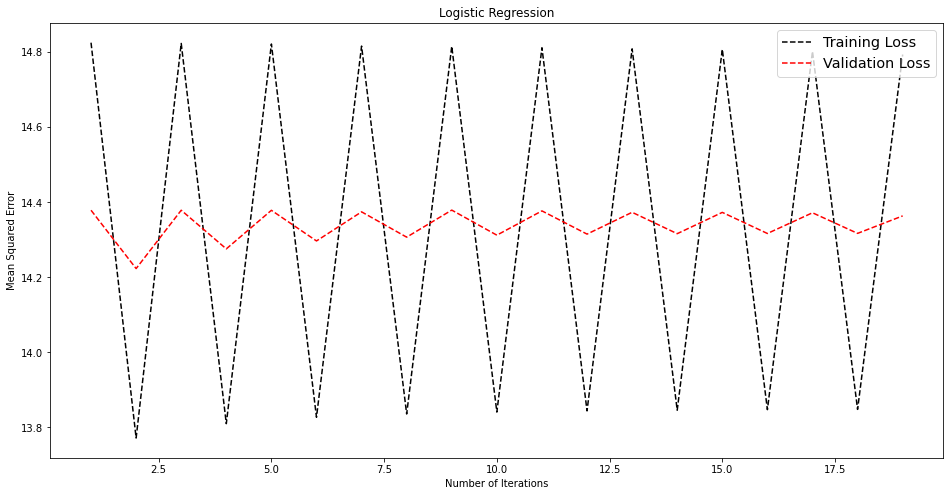

In [ ]:
plotErrorCurves(train_history, val_history, title = "Logistic Regression" )

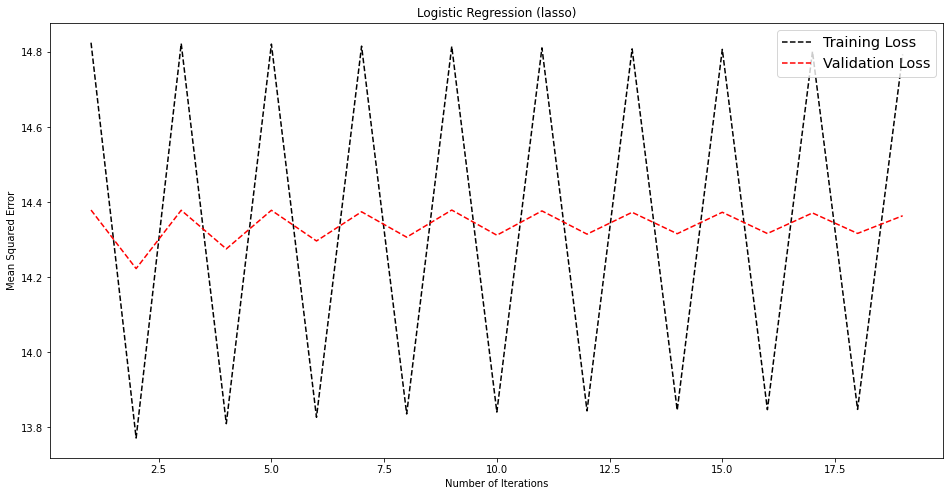

In [ ]:
plotErrorCurves(lasso_train_history, lasso_val_history, title = "Logistic Regression (lasso)" )